## Imports

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os

import seaborn as sns
import matplotlib.pyplot as plt
import sys

import skimage
from skimage.color import rgb2hsv
from skimage.transform import rescale, resize
from tqdm import tqdm

import sys
import os

from sklearn.metrics import classification_report


import bz2, pickle, _pickle as cPickle

import random

# random.seed(1234)

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"/Modules/Testing")
import testing_module

SAVE_DIR = "../Pickled Datasets/"

COPIES = 2
N_DIGITS = 3
HEIGHT = 25
WIDTH  = 25


PLOT_SAVE = "../Plots/loss-curves/"

def compressed_pickle(name: str, data):
    with bz2.BZ2File(os.path.join(SAVE_DIR, "{}.pbz2".format(name)), 'w') as f:
        cPickle.dump(data, f)

def decompress_pickle(file):
    data = bz2.BZ2File(file, 'rb')
    data = cPickle.load(data)
    return data

def plot_history(history):
    acc=history.history['accuracy']
    val_acc=history.history['val_accuracy']
    loss=history.history['loss']
    val_loss=history.history['val_loss']
    epochs=range(len(acc))

    fig, ax = plt.subplots(1, 2, figsize = (12, 6))
    ax[0].plot(epochs, acc, 'r', label = "Training Accuracy")
    ax[0].plot(epochs, val_acc, 'b', label = "Validation Accuracy")
    ax[0].legend()
    ax[0].set_title('Training and Validation Accuracy')
    ax[0].set_xlabel("Epochs")
    
    ax[1].plot(epochs, loss, 'r', label = "Training Loss")
    ax[1].plot(epochs, val_loss, 'b', label = "Validation Loss")
    ax[1].set_title('Training and Validation Losses')
    ax[1].set_xlabel("Epochs")
    plt.show()

    return (fig, ax)


SKImage rescales the image for us! Which means that we don't need to rescale by 255.0 anymore, saving us needlessly spent time and effort. There is another Augmentor library which can be used for data augmentation. We can simply sample the augmented images henceforth!

## Preliminary setup

In [2]:
sys.path.append(os.path.dirname(os.path.join((os.path.pardir), "Modules")))

origin_dir = os.path.join(os.path.pardir, 'Data')
new_dir_path = os.path.join(os.path.pardir, 'Data', 'cell_images')

#for local systems
train_csv = os.path.join(origin_dir, 'train.csv')
test_csv = os.path.join(origin_dir, 'test.csv')
val_csv = os.path.join(origin_dir, 'val.csv')

from Modules.labelling import Labelling

# download = Data_Download(origin_dir)
# data_dir = download.resize_image(new_dir_path, 44, 44)

lab = Labelling()
lab.label('../Data/cell_images/', exclude_mislabeled= True)      # function to label the dataset
train_csv, val_csv, test_csv = lab.train_test_val_split('../Data/', '../Data/cell_images/labels.csv', random_state = 1234)

In [3]:
train_data = pd.read_csv(train_csv)
val_data   = pd.read_csv(val_csv)
test_data  = pd.read_csv(test_csv)

### Reading images

../Data/cell_images/Parasitized\C39P4thinF_original_IMG_20150622_105102_cell_95.png
0.9966666666666667


100%|██████████| 2617/2617 [00:02<00:00, 1202.93it/s]


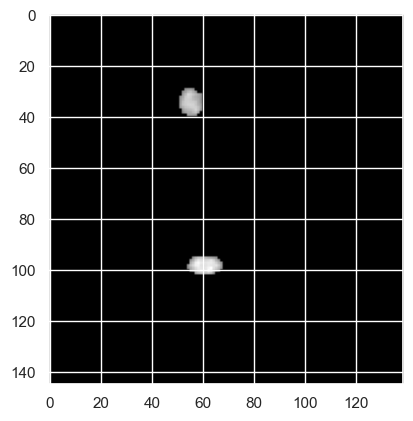

In [4]:
def read_image(path):
    '''Function to read images given a path and return an array'''
    return skimage.io.imread(path)

i = 14

print(train_data['Image_Path'][i])
image = rgb2hsv(skimage.io.imread(train_data['Image_Path'][i]))
print(np.max(image))
result = ((image > 0.5)*image)[..., 1]
plt.imshow(result, 'gray')


tqdm.pandas()
train_data['image_arr'] = train_data['Image_Path'].progress_apply(lambda x: read_image(x))
val_data['image_arr']   = val_data['Image_Path'].progress_apply(lambda x: read_image(x))
test_data['image_arr']  = test_data['Image_Path'].progress_apply(lambda x: read_image(x))


x_train, y_train = train_data['image_arr'].to_numpy(), train_data['Parasitized'].to_numpy()
x_val  , y_val   = val_data['image_arr'].to_numpy()  , val_data['Parasitized'].to_numpy()
x_test , y_test  = test_data['image_arr'].to_numpy() , test_data['Parasitized'].to_numpy()

## Data Augmentation

In [5]:
import albumentations as A
import cv2

augment = A.augmentations.geometric.transforms.Affine(
    translate_percent = 0.1,
    rotate = 60,
    shear = 30
    )

augment = A.ShiftScaleRotate(scale_limit = (-0.2, 0), rotate_limit= 90, border_mode=cv2.BORDER_CONSTANT, always_apply= True)

transform = A.Compose(
    [augment,
    A.VerticalFlip(p = 0.5),
    A.HorizontalFlip(p = 0.5),
    A.augmentations.geometric.Affine(shear = 7.5),
    A.Resize(HEIGHT, WIDTH, always_apply= True)
    ]
)

aug_dataset = []
aug_labels = []


for i, lab in tqdm(zip(x_train, y_train)):
    for _ in range(COPIES):
        aug_dataset.append(transform(image = i)['image'])
        aug_labels.append(lab)

x_train_aug = np.array(aug_dataset)
y_train_aug = np.array(aug_labels)

np.unique(y_train_aug, return_counts = True)

20601it [00:14, 1437.33it/s]


(array([0., 1.]), array([20520, 20682], dtype=int64))

### Resizing

In [6]:
temp = []
for img in tqdm(x_train):
    temp.append(resize(img, (HEIGHT, WIDTH)))
x_train = np.array(temp)


temp = []
for img in tqdm(x_val):
    temp.append(resize(img, (HEIGHT, WIDTH)))
x_val = np.array(temp)


temp = []
for img in tqdm(x_test):
    temp.append(resize(img, (HEIGHT, WIDTH)))
x_test = np.array(temp)

100%|██████████| 2617/2617 [00:02<00:00, 1174.69it/s]


## Saving Data

In [7]:
# compressed_pickle("x_train_aug", x_train_aug)
# compressed_pickle("y_train_aug", y_train_aug)
# compressed_pickle("x_train", x_train)
# compressed_pickle("y_train", y_train)
# compressed_pickle("x_val", x_val)
# compressed_pickle("y_val", y_val)
# compressed_pickle("x_test", x_test)
# compressed_pickle("y_test", y_test)

## Loading Data

In [8]:
x_train_aug = decompress_pickle(SAVE_DIR + 'x_train_aug.pbz2')
y_train_aug = decompress_pickle(SAVE_DIR + 'y_train_aug.pbz2')
x_train = decompress_pickle(SAVE_DIR + 'x_train.pbz2')
y_train = decompress_pickle(SAVE_DIR + 'y_train.pbz2')
x_val = decompress_pickle(SAVE_DIR + 'x_val.pbz2')
y_val = decompress_pickle(SAVE_DIR + 'y_val.pbz2')
x_test = decompress_pickle(SAVE_DIR + 'x_test.pbz2')
y_test = decompress_pickle(SAVE_DIR + 'y_test.pbz2')

print("augmented: ", x_train_aug.shape, y_train_aug.shape)
print("train: ", x_train.shape, y_train.shape)
print("val: ", x_val.shape, y_val.shape)
print("test: ", x_test.shape, y_test.shape)

augmented:  (41202, 25, 25, 3) (41202,)
train:  (20601, 25, 25, 3) (20601,)
val:  (2943, 25, 25, 3) (2943,)
test:  (2617, 25, 25, 3) (2617,)


In [9]:
n_aug_train = x_train_aug.shape[0]
n_train     = x_train.shape[0]
n_val       = x_val.shape[0]
n_test      = x_test.shape[0]

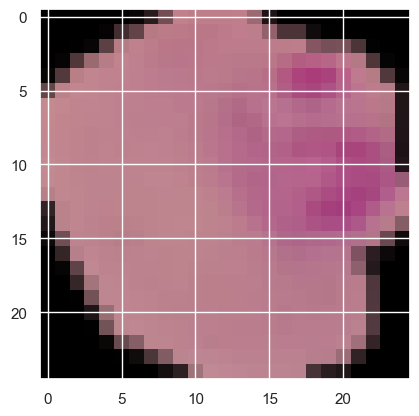

In [10]:
plt.imshow(x_train[3])

## RGB Modeling

### Unaugmented

#### Naive Bayes

In [11]:
from sklearn import naive_bayes

nb_cls = naive_bayes.GaussianNB()
nb_cls.fit(x_train.reshape(n_train, -1), y_train)
preds_train = nb_cls.predict(x_train.reshape(n_train, -1))
preds_val   = nb_cls.predict(x_val.reshape(n_val, -1))
preds_test  = nb_cls.predict(x_test.reshape(n_test, -1))

print("Training Classification Report: \n", classification_report(y_train, preds_train, digits = N_DIGITS))
print("\nValidation Classification Report: \n", classification_report(y_val, preds_val, digits = N_DIGITS))
print("\nTesting Classification Report: \n", classification_report(y_test, preds_test, digits = N_DIGITS))

# eval = testing_module.ModelEvaluation(y_val, 
#     nb_cls.predict(x_val.reshape(n_val, -1)),
#     model_reference_name = 'Naive Bayes',
#     model_type = 'classification',
#     plot_classification_metric = ['roc_auc']) # if classification
# eval.evaluate(evaluate_save= True, plots_show = True)

Training Classification Report: 
               precision    recall  f1-score   support

         0.0      0.611     0.746     0.672     10260
         1.0      0.677     0.530     0.594     10341

    accuracy                          0.637     20601
   macro avg      0.644     0.638     0.633     20601
weighted avg      0.644     0.637     0.633     20601


Validation Classification Report: 
               precision    recall  f1-score   support

         0.0      0.620     0.761     0.683      1466
         1.0      0.693     0.538     0.606      1477

    accuracy                          0.649      2943
   macro avg      0.657     0.649     0.644      2943
weighted avg      0.657     0.649     0.644      2943


Testing Classification Report: 
               precision    recall  f1-score   support

         0.0      0.613     0.766     0.681      1303
         1.0      0.692     0.521     0.595      1314

    accuracy                          0.643      2617
   macro avg      0.653

#### Logistic Regression

Epoch 1/100
41/41 [==============================] - 1s 6ms/step - loss: 0.6932 - accuracy: 0.5617 - val_loss: 0.6562 - val_accuracy: 0.6201
Epoch 2/100
41/41 [==============================] - 0s 3ms/step - loss: 0.6506 - accuracy: 0.6225 - val_loss: 0.6376 - val_accuracy: 0.6388
Epoch 3/100
41/41 [==============================] - 0s 3ms/step - loss: 0.6345 - accuracy: 0.6395 - val_loss: 0.6275 - val_accuracy: 0.6466
Epoch 4/100
41/41 [==============================] - 0s 4ms/step - loss: 0.6320 - accuracy: 0.6384 - val_loss: 0.6235 - val_accuracy: 0.6534
Epoch 5/100
41/41 [==============================] - 0s 3ms/step - loss: 0.6189 - accuracy: 0.6576 - val_loss: 0.6195 - val_accuracy: 0.6561
Epoch 6/100
41/41 [==============================] - 0s 3ms/step - loss: 0.6146 - accuracy: 0.6629 - val_loss: 0.6109 - val_accuracy: 0.6694
Epoch 7/100
41/41 [==============================] - 0s 4ms/step - loss: 0.6109 - accuracy: 0.6656 - val_loss: 0.6091 - val_accuracy: 0.6697
Epoch 8/100
4

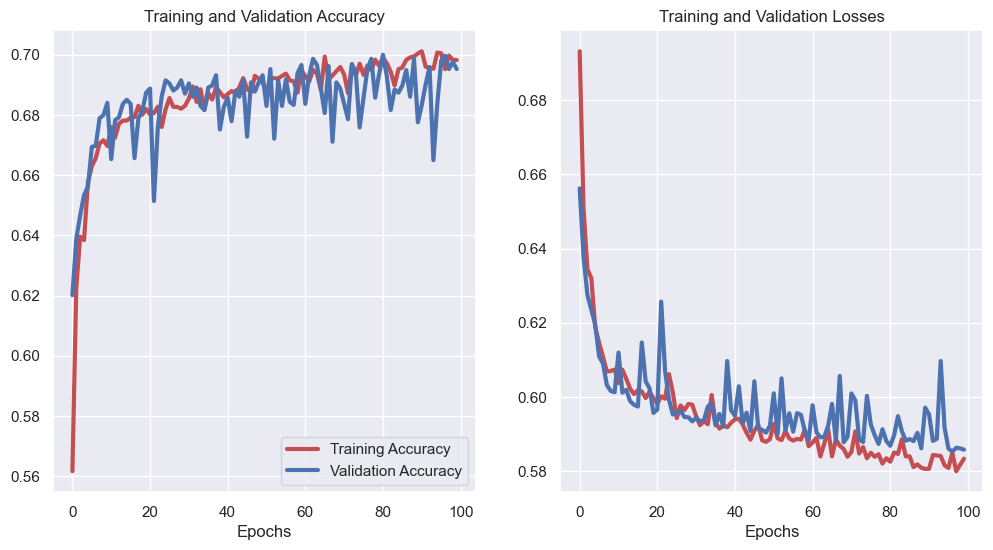

Training Classification Report: 
               precision    recall  f1-score   support

         0.0      0.706     0.702     0.704     10260
         1.0      0.706     0.709     0.708     10341

    accuracy                          0.706     20601
   macro avg      0.706     0.706     0.706     20601
weighted avg      0.706     0.706     0.706     20601


Validation Classification Report: 
               precision    recall  f1-score   support

         0.0      0.697     0.701     0.699      1466
         1.0      0.702     0.698     0.700      1477

    accuracy                          0.700      2943
   macro avg      0.700     0.700     0.700      2943
weighted avg      0.700     0.700     0.700      2943


Testing Classification Report: 
               precision    recall  f1-score   support

         0.0      0.693     0.698     0.695      1303
         1.0      0.698     0.693     0.696      1314

    accuracy                          0.695      2617
   macro avg      0.695

In [12]:
from sklearn.linear_model import LogisticRegression

logreg_cls =  tf.keras.Sequential([tf.keras.layers.Dense(2, activation = 'sigmoid', input_dim = HEIGHT * WIDTH * 3)])
logreg_cls.compile(optimizer = tf.optimizers.Adam(0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
history = logreg_cls.fit(x_train.reshape(n_train, -1), 
                        y_train,
                        batch_size = 512,
                        validation_data=[x_val.reshape(n_val, -1), y_val],
                        validation_batch_size=128,
                        epochs = 100,
                        callbacks =  [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10),
                                     tf.keras.callbacks.ModelCheckpoint(str = 'val_loss', save_best_only = True, save_weights_only = True, filepath= "LR_No_Aug")],
                        verbose = 1)

logreg_cls.load_weights('LR_No_Aug')
preds_train = np.argmax(logreg_cls.predict(x_train.reshape(n_train, -1)), axis = 1)
preds_val   = np.argmax(logreg_cls.predict(x_val.reshape(n_val, -1)), axis = 1)
preds_test  = np.argmax(logreg_cls.predict(x_test.reshape(n_test, -1)), axis = 1)

fig, ax = plot_history(history)

fig.savefig(PLOT_SAVE + "logreg_unaug_losscurve.png", facecolor = 'white')

print("Training Classification Report: \n", classification_report(y_train, preds_train, digits = N_DIGITS))
print("\nValidation Classification Report: \n", classification_report(y_val, preds_val, digits = N_DIGITS))
print("\nTesting Classification Report: \n", classification_report(y_test, preds_test, digits = N_DIGITS))

#### Decision Trees

In [13]:
from sklearn.tree import DecisionTreeClassifier

dt_cls =  DecisionTreeClassifier(criterion = 'gini', splitter = 'best', max_depth = 5, min_samples_split = 2, )
dt_cls.fit(x_train.reshape(n_train, -1), y_train)
preds_train = dt_cls.predict(x_train.reshape(n_train, -1))
preds_val   = dt_cls.predict(x_val.reshape(n_val, -1))
preds_test  = dt_cls.predict(x_test.reshape(n_test, -1))

print("Training Classification Report: \n", classification_report(y_train, preds_train, digits = N_DIGITS))
print("\nValidation Classification Report: \n", classification_report(y_val, preds_val, digits = N_DIGITS))
print("\nTesting Classification Report: \n", classification_report(y_test, preds_test, digits = N_DIGITS))

# eval = testing_module.ModelEvaluation(y_val, 
#     nb_cls.predict(x_val.reshape(n_val, -1)),
#     model_reference_name = 'Naive Bayes',
#     model_type = 'classification',
#     plot_classification_metric = ['roc_auc']) # if classification
# eval.evaluate(evaluate_save= True, plots_show = True)

Training Classification Report: 
               precision    recall  f1-score   support

         0.0      0.685     0.774     0.727     10260
         1.0      0.743     0.646     0.691     10341

    accuracy                          0.710     20601
   macro avg      0.714     0.710     0.709     20601
weighted avg      0.714     0.710     0.709     20601


Validation Classification Report: 
               precision    recall  f1-score   support

         0.0      0.677     0.774     0.722      1466
         1.0      0.738     0.633     0.681      1477

    accuracy                          0.703      2943
   macro avg      0.707     0.703     0.702      2943
weighted avg      0.707     0.703     0.702      2943


Testing Classification Report: 
               precision    recall  f1-score   support

         0.0      0.661     0.748     0.702      1303
         1.0      0.713     0.620     0.663      1314

    accuracy                          0.684      2617
   macro avg      0.687

#### XGBoost

In [14]:
tf.keras.backend.clear_session()

from xgboost import XGBClassifier

xgb_cls = XGBClassifier(max_depth = 5, objective = 'reg:logistic',
                            num_parallel_tree = 20, booster = 'gbtree',
                            gamma = 0.5, tree_method = 'gpu_hist', subsample = 0.4, reg_lambda = 1)
xgb_cls.fit(x_train.reshape(n_train, -1), y_train)
preds_train = xgb_cls.predict(x_train.reshape(n_train, -1))
preds_val   = xgb_cls.predict(x_val.reshape(n_val, -1))
preds_test  = xgb_cls.predict(x_test.reshape(n_test, -1))

print("Training Classification Report: \n", classification_report(y_train, preds_train, digits = N_DIGITS))
print("\nValidation Classification Report: \n", classification_report(y_val, preds_val, digits = N_DIGITS))
print("\nTesting Classification Report: \n", classification_report(y_test, preds_test, digits = N_DIGITS))
                  

Training Classification Report: 
               precision    recall  f1-score   support

         0.0      0.966     0.983     0.974     10260
         1.0      0.983     0.966     0.974     10341

    accuracy                          0.974     20601
   macro avg      0.974     0.974     0.974     20601
weighted avg      0.975     0.974     0.974     20601


Validation Classification Report: 
               precision    recall  f1-score   support

         0.0      0.842     0.873     0.857      1466
         1.0      0.869     0.837     0.853      1477

    accuracy                          0.855      2943
   macro avg      0.855     0.855     0.855      2943
weighted avg      0.855     0.855     0.855      2943


Testing Classification Report: 
               precision    recall  f1-score   support

         0.0      0.842     0.861     0.851      1303
         1.0      0.859     0.839     0.849      1314

    accuracy                          0.850      2617
   macro avg      0.850

#### SVM

In [15]:
from sklearn.svm import SVC

svm_cls = SVC(kernel = 'poly', degree = 3, gamma = 'auto', max_iter = 250, verbose= True)
svm_cls.fit(x_train.reshape(n_train, -1), y_train)
preds_train = svm_cls.predict(x_train.reshape(n_train, -1))
preds_val   = svm_cls.predict(x_val.reshape(n_val, -1))
preds_test  = svm_cls.predict(x_test.reshape(n_test, -1))

print("Training Classification Report: \n", classification_report(y_train, preds_train, digits = N_DIGITS))
print("\nValidation Classification Report: \n", classification_report(y_val, preds_val, digits = N_DIGITS))
print("\nTesting Classification Report: \n", classification_report(y_test, preds_test, digits = N_DIGITS))
                  

[LibSVM]

c:\ProgramData\Anaconda3\envs\ml\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=250).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Training Classification Report: 
               precision    recall  f1-score   support

         0.0      0.581     0.102     0.174     10260
         1.0      0.510     0.927     0.658     10341

    accuracy                          0.516     20601
   macro avg      0.545     0.515     0.416     20601
weighted avg      0.545     0.516     0.417     20601


Validation Classification Report: 
               precision    recall  f1-score   support

         0.0      0.585     0.101     0.172      1466
         1.0      0.510     0.929     0.659      1477

    accuracy                          0.516      2943
   macro avg      0.548     0.515     0.415      2943
weighted avg      0.547     0.516     0.416      2943


Testing Classification Report: 
               precision    recall  f1-score   support

         0.0      0.590     0.106     0.180      1303
         1.0      0.511     0.927     0.659      1314

    accuracy                          0.518      2617
   macro avg      0.550

#### Transfer Learning

Epoch 1/50
322/322 [==============================] - 10s 19ms/step - loss: 0.2169 - accuracy: 0.9198 - val_loss: 0.1573 - val_accuracy: 0.9368
Epoch 2/50
322/322 [==============================] - 6s 17ms/step - loss: 0.1281 - accuracy: 0.9490 - val_loss: 0.1111 - val_accuracy: 0.9616
Epoch 3/50
322/322 [==============================] - 5s 15ms/step - loss: 0.1070 - accuracy: 0.9568 - val_loss: 0.1126 - val_accuracy: 0.9582
Epoch 4/50
322/322 [==============================] - 5s 16ms/step - loss: 0.1036 - accuracy: 0.9583 - val_loss: 0.1096 - val_accuracy: 0.9592
Epoch 5/50
322/322 [==============================] - 5s 16ms/step - loss: 0.0919 - accuracy: 0.9643 - val_loss: 0.1073 - val_accuracy: 0.9633
Epoch 6/50
322/322 [==============================] - 5s 15ms/step - loss: 0.0864 - accuracy: 0.9659 - val_loss: 0.1379 - val_accuracy: 0.9565
Epoch 7/50
322/322 [==============================] - 5s 15ms/step - loss: 0.0867 - accuracy: 0.9675 - val_loss: 0.1259 - val_accuracy: 0.963

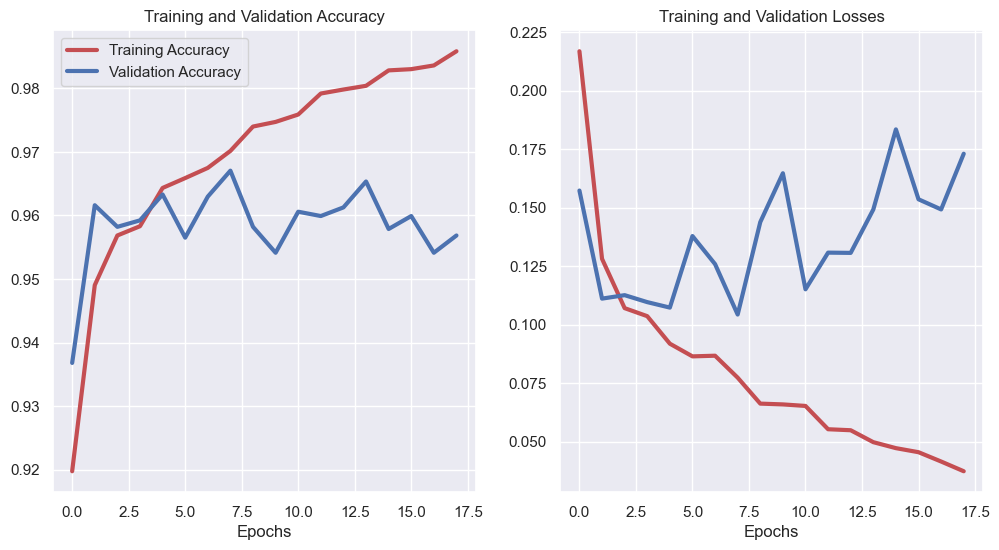

82/82 [==============================] - 1s 7ms/step
Training Classification Report: 
               precision    recall  f1-score   support

         0.0      0.969     0.986     0.977     10260
         1.0      0.986     0.968     0.977     10341

    accuracy                          0.977     20601
   macro avg      0.977     0.977     0.977     20601
weighted avg      0.977     0.977     0.977     20601


Validation Classification Report: 
               precision    recall  f1-score   support

         0.0      0.961     0.973     0.967      1466
         1.0      0.973     0.961     0.967      1477

    accuracy                          0.967      2943
   macro avg      0.967     0.967     0.967      2943
weighted avg      0.967     0.967     0.967      2943


Testing Classification Report: 
               precision    recall  f1-score   support

         0.0      0.947     0.969     0.958      1303
         1.0      0.968     0.946     0.957      1314

    accuracy            

In [16]:
imagenet = tf.keras.applications.Xception(
    weights = 'imagenet',
    include_top = False,
    input_shape = (72, 72, 3)
)
imagenet.trainable = False

trans_learn = tf.keras.Sequential([
    tf.keras.layers.Resizing(72, 72),
    imagenet,

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(2, activation = 'sigmoid')
])

trans_learn.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.003),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

history = trans_learn.fit(
            x_train, y_train, batch_size = 64,
            shuffle = True,
            epochs = 50,
            validation_data = [x_val, y_val],
            validation_batch_size = 32,
            callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10),
                        tf.keras.callbacks.ModelCheckpoint(str = 'val_loss', save_best_only = True, save_weights_only = True, filepath= "TL_No_Aug")]
        )
fig, ax = plot_history(history)

trans_learn.load_weights('TL_No_Aug')

fig.savefig(PLOT_SAVE + "TL_unaug_losscurve.png", facecolor = 'white')
preds_train = np.argmax(trans_learn.predict(x_train), axis = 1)
preds_val   = np.argmax(trans_learn.predict(x_val), axis = 1)
preds_test  = np.argmax(trans_learn.predict(x_test), axis = 1)

print("Training Classification Report: \n", classification_report(y_train, preds_train, digits = N_DIGITS))
print("\nValidation Classification Report: \n", classification_report(y_val, preds_val, digits = N_DIGITS))
print("\nTesting Classification Report: \n", classification_report(y_test, preds_test, digits = N_DIGITS))



#### CNN Model

Epoch 1/50
21/21 [==============================] - 1s 18ms/step - loss: 0.7049 - accuracy: 0.5098 - val_loss: 0.6894 - val_accuracy: 0.6120
Epoch 2/50
21/21 [==============================] - 0s 9ms/step - loss: 0.6614 - accuracy: 0.6182 - val_loss: 0.6315 - val_accuracy: 0.6453
Epoch 3/50
21/21 [==============================] - 0s 9ms/step - loss: 0.5928 - accuracy: 0.6978 - val_loss: 0.5595 - val_accuracy: 0.7149
Epoch 4/50
21/21 [==============================] - 0s 9ms/step - loss: 0.5280 - accuracy: 0.7513 - val_loss: 0.4701 - val_accuracy: 0.7846
Epoch 5/50
21/21 [==============================] - 0s 9ms/step - loss: 0.4577 - accuracy: 0.7992 - val_loss: 0.4059 - val_accuracy: 0.8233
Epoch 6/50
21/21 [==============================] - 0s 9ms/step - loss: 0.4014 - accuracy: 0.8275 - val_loss: 0.3543 - val_accuracy: 0.8410
Epoch 7/50
21/21 [==============================] - 0s 9ms/step - loss: 0.3351 - accuracy: 0.8646 - val_loss: 0.2760 - val_accuracy: 0.8831
Epoch 8/50
21/21 [=

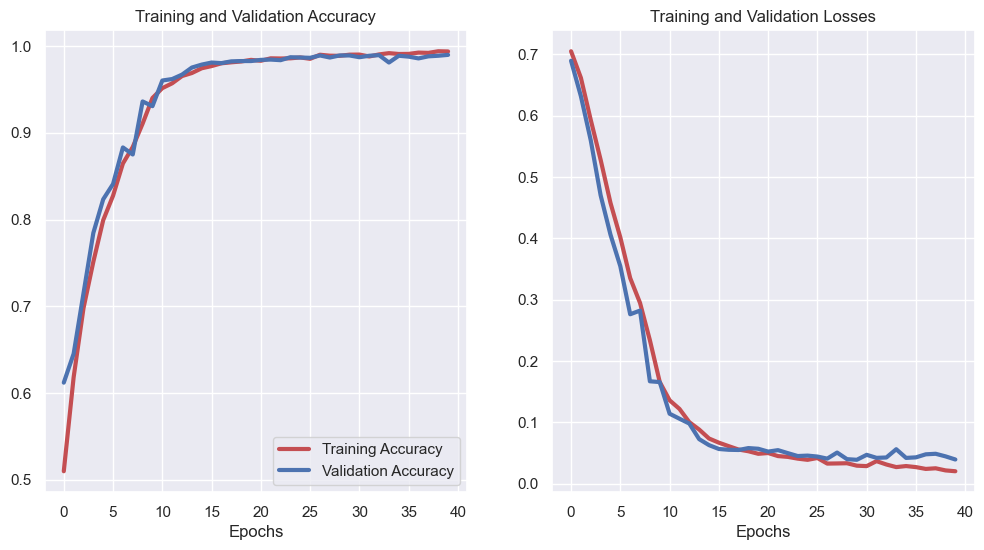

82/82 [==============================] - 0s 1ms/step
Training Classification Report: 
               precision    recall  f1-score   support

         0.0      0.991     0.995     0.993     10260
         1.0      0.995     0.991     0.993     10341

    accuracy                          0.993     20601
   macro avg      0.993     0.993     0.993     20601
weighted avg      0.993     0.993     0.993     20601


Validation Classification Report: 
               precision    recall  f1-score   support

         0.0      0.988     0.990     0.989      1466
         1.0      0.990     0.988     0.989      1477

    accuracy                          0.989      2943
   macro avg      0.989     0.989     0.989      2943
weighted avg      0.989     0.989     0.989      2943


Testing Classification Report: 
               precision    recall  f1-score   support

         0.0      0.980     0.995     0.988      1303
         1.0      0.995     0.980     0.988      1314

    accuracy            

In [17]:
cnn = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), padding = 'same', activation = 'relu', input_shape = x_train[0].shape),
    tf.keras.layers.MaxPool2D((3,3), padding = 'same'),

    tf.keras.layers.Conv2D(32, (2,2), padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPool2D((2,2), padding = 'same'),


    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation = 'sigmoid')
])

cnn.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.003),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

history = cnn.fit(
            x_train, y_train, batch_size = 1024,
            epochs = 50,
            validation_data = [x_val, y_val],
            validation_batch_size = 256,
            callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10),
                         tf.keras.callbacks.ModelCheckpoint(str = 'val_loss', save_best_only = True, save_weights_only = True, filepath= "CNN_No_Aug")]
        )


cnn.load_weights('CNN_No_Aug')
fig, ax = plot_history(history)

fig.savefig(PLOT_SAVE + "CNN_unaug_losscurve.png", facecolor = 'white')
preds_train = np.argmax(cnn.predict(x_train), axis = 1)
preds_val   = np.argmax(cnn.predict(x_val), axis = 1)
preds_test  = np.argmax(cnn.predict(x_test), axis = 1)

print("Training Classification Report: \n", classification_report(y_train, preds_train, digits = N_DIGITS))
print("\nValidation Classification Report: \n", classification_report(y_val, preds_val, digits = N_DIGITS))
print("\nTesting Classification Report: \n", classification_report(y_test, preds_test, digits = N_DIGITS))

### Augmented Dataset

#### Naive Bayes

In [18]:
from sklearn import naive_bayes

nb_cls = naive_bayes.GaussianNB()
nb_cls.fit(x_train_aug.reshape(n_aug_train, -1), y_train_aug)
preds_train = nb_cls.predict(x_train_aug.reshape(n_aug_train, -1))
preds_val   = nb_cls.predict(x_val.reshape(n_val, -1))
preds_test  = nb_cls.predict(x_test.reshape(n_test, -1))

print("Training Classification Report: \n", classification_report(y_train_aug, preds_train, digits = N_DIGITS))
print("\nValidation Classification Report: \n", classification_report(y_val, preds_val, digits = N_DIGITS))
print("\nTesting Classification Report: \n", classification_report(y_test, preds_test, digits = N_DIGITS))

Training Classification Report: 
               precision    recall  f1-score   support

         0.0      0.602     0.774     0.677     20520
         1.0      0.687     0.492     0.573     20682

    accuracy                          0.632     41202
   macro avg      0.644     0.633     0.625     41202
weighted avg      0.645     0.632     0.625     41202


Validation Classification Report: 
               precision    recall  f1-score   support

         0.0      0.000     0.000     0.000      1466
         1.0      0.502     0.999     0.668      1477

    accuracy                          0.502      2943
   macro avg      0.251     0.500     0.334      2943
weighted avg      0.252     0.502     0.335      2943


Testing Classification Report: 
               precision    recall  f1-score   support

         0.0      0.000     0.000     0.000      1303
         1.0      0.502     0.998     0.668      1314

    accuracy                          0.501      2617
   macro avg      0.251

#### Logistic Regression

Epoch 1/100
81/81 [==============================] - 0s 4ms/step - loss: 29.5481 - accuracy: 0.5383 - val_loss: 0.6844 - val_accuracy: 0.5481
Epoch 2/100
81/81 [==============================] - 0s 2ms/step - loss: 13.2085 - accuracy: 0.5641 - val_loss: 0.6813 - val_accuracy: 0.6232
Epoch 3/100
81/81 [==============================] - 0s 3ms/step - loss: 11.8124 - accuracy: 0.5719 - val_loss: 0.6839 - val_accuracy: 0.5753
Epoch 4/100
81/81 [==============================] - 0s 2ms/step - loss: 9.8759 - accuracy: 0.5758 - val_loss: 0.6845 - val_accuracy: 0.5729
Epoch 5/100
81/81 [==============================] - 0s 2ms/step - loss: 12.4358 - accuracy: 0.5569 - val_loss: 0.6796 - val_accuracy: 0.6551
Epoch 6/100
81/81 [==============================] - 0s 2ms/step - loss: 8.3969 - accuracy: 0.5874 - val_loss: 0.6835 - val_accuracy: 0.6378
Epoch 7/100
81/81 [==============================] - 0s 2ms/step - loss: 7.0178 - accuracy: 0.5850 - val_loss: 0.6853 - val_accuracy: 0.6381
Epoch 8/1

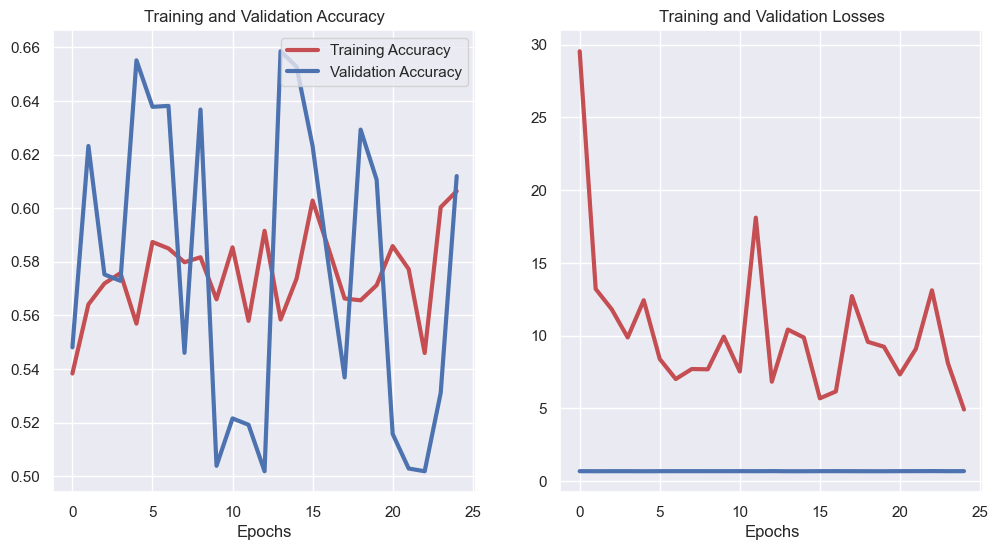

Training Classification Report: 
               precision    recall  f1-score   support

         0.0      0.506     0.983     0.669     20520
         1.0      0.749     0.049     0.092     20682

    accuracy                          0.514     41202
   macro avg      0.628     0.516     0.380     41202
weighted avg      0.628     0.514     0.379     41202


Validation Classification Report: 
               precision    recall  f1-score   support

         0.0      0.634     0.522     0.573      1466
         1.0      0.596     0.701     0.645      1477

    accuracy                          0.612      2943
   macro avg      0.615     0.612     0.609      2943
weighted avg      0.615     0.612     0.609      2943


Testing Classification Report: 
               precision    recall  f1-score   support

         0.0      0.637     0.529     0.578      1303
         1.0      0.600     0.702     0.647      1314

    accuracy                          0.616      2617
   macro avg      0.619

In [19]:
from sklearn.linear_model import LogisticRegression

logreg_cls =  tf.keras.Sequential([tf.keras.layers.Dense(2, activation = 'sigmoid', input_dim = HEIGHT * WIDTH * 3)])
logreg_cls.compile(optimizer = tf.optimizers.Adam(0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
history = logreg_cls.fit(x_train_aug.reshape(n_aug_train, -1), 
                        y_train_aug,
                        batch_size = 512,
                        validation_data=[x_val.reshape(n_val, -1), y_val],
                        validation_batch_size=128,
                        epochs = 100,
                        callbacks =  [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10),
                                    tf.keras.callbacks.ModelCheckpoint(str = 'val_loss', save_best_only = True, save_weights_only = True, filepath= "LR_Aug")])
preds_train = np.argmax(logreg_cls.predict(x_train_aug.reshape(n_aug_train, -1)), axis = 1)
preds_val   = np.argmax(logreg_cls.predict(x_val.reshape(n_val, -1)), axis = 1)
preds_test  = np.argmax(logreg_cls.predict(x_test.reshape(n_test, -1)), axis = 1)

logreg_cls.load_weights('LR_Aug')
fig, ax = plot_history(history)

fig.savefig(PLOT_SAVE + "logreg_aug_losscurve.png", facecolor = 'white')

print("Training Classification Report: \n", classification_report(y_train_aug, preds_train, digits = N_DIGITS))
print("\nValidation Classification Report: \n", classification_report(y_val, preds_val, digits = N_DIGITS))
print("\nTesting Classification Report: \n", classification_report(y_test, preds_test, digits = N_DIGITS))

#### Decision Trees

In [20]:
from sklearn.tree import DecisionTreeClassifier

dt_cls =  DecisionTreeClassifier(criterion = 'gini', splitter = 'best', max_depth = 5, min_samples_split = 2, )
dt_cls.fit(x_train_aug.reshape(n_aug_train, -1), y_train_aug)
preds_train = dt_cls.predict(x_train_aug.reshape(n_aug_train, -1))
preds_val   = dt_cls.predict(x_val.reshape(n_val, -1))
preds_test  = dt_cls.predict(x_test.reshape(n_test, -1))

print("Training Classification Report: \n", classification_report(y_train_aug, preds_train, digits = N_DIGITS))
print("\nValidation Classification Report: \n", classification_report(y_val, preds_val, digits = N_DIGITS))
print("\nTesting Classification Report: \n", classification_report(y_test, preds_test, digits = N_DIGITS))

# eval = testing_module.ModelEvaluation(y_val, 
#     nb_cls.predict(x_val.reshape(n_val, -1)),
#     model_reference_name = 'Naive Bayes',
#     model_type = 'classification',
#     plot_classification_metric = ['roc_auc']) # if classification
# eval.evaluate(evaluate_save= True, plots_show = True)

Training Classification Report: 
               precision    recall  f1-score   support

         0.0      0.675     0.758     0.714     20520
         1.0      0.727     0.638     0.679     20682

    accuracy                          0.698     41202
   macro avg      0.701     0.698     0.697     41202
weighted avg      0.701     0.698     0.697     41202


Validation Classification Report: 
               precision    recall  f1-score   support

         0.0      0.000     0.000     0.000      1466
         1.0      0.502     1.000     0.668      1477

    accuracy                          0.502      2943
   macro avg      0.251     0.500     0.334      2943
weighted avg      0.252     0.502     0.335      2943


Testing Classification Report: 
               precision    recall  f1-score   support

         0.0      0.000     0.000     0.000      1303
         1.0      0.502     1.000     0.669      1314

    accuracy                          0.502      2617
   macro avg      0.251

c:\ProgramData\Anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\envs\m

#### XGBoost

In [21]:
from xgboost import XGBClassifier

xgb_cls = XGBClassifier(max_depth = 5, objective = 'reg:logistic',
                            num_parallel_tree = 20, booster = 'gbtree',
                            gamma = 0.5, tree_method = 'gpu_hist', subsample = 0.4, reg_lambda = 1)
xgb_cls.fit(x_train_aug.reshape(n_aug_train, -1), y_train_aug)
preds_train = xgb_cls.predict(x_train_aug.reshape(n_aug_train, -1))
preds_val   = xgb_cls.predict(x_val.reshape(n_val, -1))
preds_test  = xgb_cls.predict(x_test.reshape(n_test, -1))

print("Training Classification Report: \n", classification_report(y_train_aug, preds_train, digits = N_DIGITS))
print("\nValidation Classification Report: \n", classification_report(y_val, preds_val, digits = N_DIGITS))
print("\nTesting Classification Report: \n", classification_report(y_test, preds_test, digits = N_DIGITS))
                  

Training Classification Report: 
               precision    recall  f1-score   support

         0.0      0.882     0.938     0.909     20520
         1.0      0.934     0.876     0.904     20682

    accuracy                          0.907     41202
   macro avg      0.908     0.907     0.907     41202
weighted avg      0.908     0.907     0.907     41202


Validation Classification Report: 
               precision    recall  f1-score   support

         0.0      0.498     1.000     0.665      1466
         1.0      0.000     0.000     0.000      1477

    accuracy                          0.498      2943
   macro avg      0.249     0.500     0.333      2943
weighted avg      0.248     0.498     0.331      2943


Testing Classification Report: 
               precision    recall  f1-score   support

         0.0      0.498     1.000     0.665      1303
         1.0      0.000     0.000     0.000      1314

    accuracy                          0.498      2617
   macro avg      0.249

c:\ProgramData\Anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\envs\m

#### SVM

In [22]:
from sklearn.svm import SVC

svm_cls = SVC(kernel = 'rbf', max_iter = 250, verbose= True)
svm_cls.fit(x_train_aug.reshape(n_aug_train, -1), y_train_aug)
preds_train = svm_cls.predict(x_train_aug.reshape(n_aug_train, -1))
preds_val   = svm_cls.predict(x_val.reshape(n_val, -1))
preds_test  = svm_cls.predict(x_test.reshape(n_test, -1))

print("Training Classification Report: \n", classification_report(y_train_aug, preds_train, digits = N_DIGITS))
print("\nValidation Classification Report: \n", classification_report(y_val, preds_val, digits = N_DIGITS))
print("\nTesting Classification Report: \n", classification_report(y_test, preds_test, digits = N_DIGITS))
                  

[LibSVM]

c:\ProgramData\Anaconda3\envs\ml\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=250).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Training Classification Report: 
               precision    recall  f1-score   support

         0.0      0.549     0.540     0.544     20520
         1.0      0.551     0.559     0.555     20682

    accuracy                          0.550     41202
   macro avg      0.550     0.550     0.550     41202
weighted avg      0.550     0.550     0.550     41202


Validation Classification Report: 
               precision    recall  f1-score   support

         0.0      0.498     1.000     0.665      1466
         1.0      0.000     0.000     0.000      1477

    accuracy                          0.498      2943
   macro avg      0.249     0.500     0.333      2943
weighted avg      0.248     0.498     0.331      2943


Testing Classification Report: 
               precision    recall  f1-score   support

         0.0      0.498     1.000     0.665      1303
         1.0      0.000     0.000     0.000      1314

    accuracy                          0.498      2617
   macro avg      0.249

c:\ProgramData\Anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\envs\m

#### Transfer Learning

Epoch 1/50
322/322 [==============================] - 11s 27ms/step - loss: 0.9920 - accuracy: 0.6904 - val_loss: 0.6933 - val_accuracy: 0.5019
Epoch 2/50
322/322 [==============================] - 8s 24ms/step - loss: 0.5274 - accuracy: 0.7363 - val_loss: 0.6942 - val_accuracy: 0.5019
Epoch 3/50
322/322 [==============================] - 8s 24ms/step - loss: 0.5034 - accuracy: 0.7530 - val_loss: 0.6957 - val_accuracy: 0.5019
Epoch 4/50
322/322 [==============================] - 8s 24ms/step - loss: 0.4875 - accuracy: 0.7627 - val_loss: 0.6979 - val_accuracy: 0.5019
Epoch 5/50
322/322 [==============================] - 8s 24ms/step - loss: 0.4754 - accuracy: 0.7703 - val_loss: 0.7004 - val_accuracy: 0.5019
Epoch 6/50
322/322 [==============================] - 8s 24ms/step - loss: 0.4673 - accuracy: 0.7740 - val_loss: 0.7044 - val_accuracy: 0.5019
Epoch 7/50
322/322 [==============================] - 8s 24ms/step - loss: 0.4680 - accuracy: 0.7729 - val_loss: 0.7088 - val_accuracy: 0.501

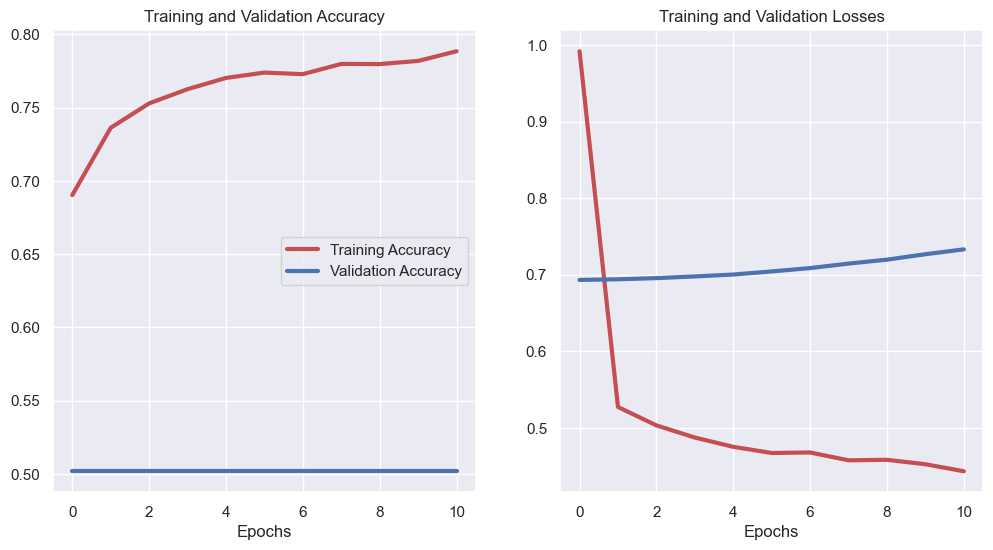

82/82 [==============================] - 1s 7ms/step
Training Classification Report: 
               precision    recall  f1-score   support

         0.0      0.684     0.887     0.772     20520
         1.0      0.841     0.594     0.696     20682

    accuracy                          0.740     41202
   macro avg      0.763     0.740     0.734     41202
weighted avg      0.763     0.740     0.734     41202


Validation Classification Report: 
               precision    recall  f1-score   support

         0.0      0.000     0.000     0.000      1466
         1.0      0.502     1.000     0.668      1477

    accuracy                          0.502      2943
   macro avg      0.251     0.500     0.334      2943
weighted avg      0.252     0.502     0.335      2943


Testing Classification Report: 
               precision    recall  f1-score   support

         0.0      0.000     0.000     0.000      1303
         1.0      0.502     1.000     0.669      1314

    accuracy            

c:\ProgramData\Anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\envs\m

In [24]:
imagenet = tf.keras.applications.Xception(
    weights = 'imagenet',
    include_top = False,
    input_shape = (72, 72, 3)
)
imagenet.trainable = False

trans_learn = tf.keras.Sequential([
    tf.keras.layers.Resizing(72, 72),
    imagenet,

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(2, activation = 'sigmoid')
])

trans_learn.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

history = trans_learn.fit(
            x_train_aug, y_train_aug, batch_size = 128,
            shuffle = True,
            epochs = 50,
            validation_data = [x_val, y_val],
            validation_batch_size = 64,
            callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10),
                        tf.keras.callbacks.ModelCheckpoint(str = 'val_loss', save_best_only = True, save_weights_only = True, filepath= "TL_Aug")]
        )

trans_learn.load_weights('TL_Aug')

fig, ax = plot_history(history)

fig.savefig(PLOT_SAVE + "TL_aug_losscurve.png", facecolor = 'white')
preds_train = np.argmax(trans_learn.predict(x_train_aug), axis = 1)
preds_val   = np.argmax(trans_learn.predict(x_val), axis = 1)
preds_test  = np.argmax(trans_learn.predict(x_test), axis = 1)

print("Training Classification Report: \n", classification_report(y_train_aug, preds_train, digits = N_DIGITS))
print("\nValidation Classification Report: \n", classification_report(y_val, preds_val, digits = N_DIGITS))
print("\nTesting Classification Report: \n", classification_report(y_test, preds_test, digits = N_DIGITS))



#### CNN Model

Epoch 1/50
161/161 [==============================] - 1s 4ms/step - loss: 2.2032 - accuracy: 0.5085 - val_loss: 0.6932 - val_accuracy: 0.4981
Epoch 2/50
161/161 [==============================] - 1s 3ms/step - loss: 0.6937 - accuracy: 0.5009 - val_loss: 0.6931 - val_accuracy: 0.5019
Epoch 3/50
161/161 [==============================] - 1s 3ms/step - loss: 0.6935 - accuracy: 0.4996 - val_loss: 0.6931 - val_accuracy: 0.5022
Epoch 4/50
161/161 [==============================] - 1s 3ms/step - loss: 0.6932 - accuracy: 0.5011 - val_loss: 0.6932 - val_accuracy: 0.4981
Epoch 5/50
161/161 [==============================] - 1s 3ms/step - loss: 0.6927 - accuracy: 0.5053 - val_loss: 0.6933 - val_accuracy: 0.4981
Epoch 6/50
161/161 [==============================] - 1s 3ms/step - loss: 0.6927 - accuracy: 0.5061 - val_loss: 0.6932 - val_accuracy: 0.4981
Epoch 7/50
161/161 [==============================] - 1s 3ms/step - loss: 0.6924 - accuracy: 0.5036 - val_loss: 0.6931 - val_accuracy: 0.5178
Epoch 

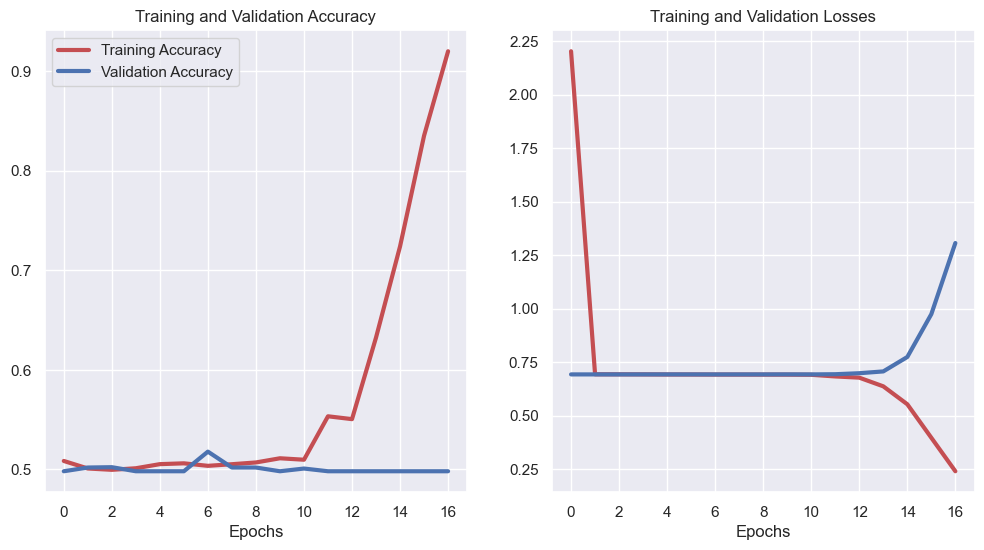

82/82 [==============================] - 0s 1ms/step
Training Classification Report: 
               precision    recall  f1-score   support

         0.0      0.516     0.968     0.673     20520
         1.0      0.758     0.100     0.176     20682

    accuracy                          0.532     41202
   macro avg      0.637     0.534     0.425     41202
weighted avg      0.637     0.532     0.424     41202


Validation Classification Report: 
               precision    recall  f1-score   support

         0.0      0.508     0.982     0.670      1466
         1.0      0.764     0.057     0.106      1477

    accuracy                          0.518      2943
   macro avg      0.636     0.520     0.388      2943
weighted avg      0.636     0.518     0.387      2943


Testing Classification Report: 
               precision    recall  f1-score   support

         0.0      0.508     0.985     0.670      1303
         1.0      0.780     0.054     0.101      1314

    accuracy            

In [25]:
cnn = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), padding = 'same', activation = 'relu', input_shape = x_train[0].shape),
    tf.keras.layers.MaxPool2D((3,3), padding = 'same'),

    tf.keras.layers.Conv2D(32, (2,2), padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPool2D((2,2), padding = 'same'),


    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation = 'sigmoid')
])

cnn.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

history = cnn.fit(
            x_train_aug, y_train_aug, batch_size = 256,
            epochs = 50,
            shuffle = True,
            validation_data = [x_val, y_val],
            validation_batch_size = 128,
            callbacks = [
                tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10),
                tf.keras.callbacks.ModelCheckpoint(str = 'val_loss', save_best_only = True, save_weights_only = True, filepath= "CNN_Aug")
            ]
        )

fig, ax = plot_history(history)

cnn.load_weights('CNN_Aug')

fig.savefig(PLOT_SAVE + "CNN_aug_losscurve.png", facecolor = 'white')
preds_train = np.argmax(cnn.predict(x_train_aug), axis = 1)
preds_val   = np.argmax(cnn.predict(x_val), axis = 1)
preds_test  = np.argmax(cnn.predict(x_test), axis = 1)

print("Training Classification Report: \n", classification_report(y_train_aug, preds_train, digits = N_DIGITS))
print("\nValidation Classification Report: \n", classification_report(y_val, preds_val, digits = N_DIGITS))
print("\nTesting Classification Report: \n", classification_report(y_test, preds_test, digits = N_DIGITS))

## HSV Modelling with only the saturation dimension

Transfer learning does not work since it requires exactly 3 input channels (Xception, VGG19, etc)

### Preparing Datasets

In [26]:
temp = []
for img in tqdm(x_train):
    temp.append(rgb2hsv(img))
temp = np.array(temp)[..., 1]
x_train = temp
x_train = x_train[..., np.newaxis]

temp = []
for img in tqdm(x_val):
    temp.append(rgb2hsv(img))
temp = np.array(temp)[..., 1]
x_val = temp
x_val = x_val[..., np.newaxis]

temp = []
for img in tqdm(x_test):
    temp.append(rgb2hsv(img))
temp = np.array(temp)[..., 1]
x_test = temp
x_test = x_test[..., np.newaxis]


temp = []
for img in tqdm(x_train_aug):
    temp.append(rgb2hsv(img))
temp = np.array(temp)[..., 1]
x_train_aug = temp
x_train_aug = x_train_aug[..., np.newaxis]



x_train.shape, x_val.shape, x_test.shape

100%|██████████| 41202/41202 [00:06<00:00, 6013.69it/s]


((20601, 25, 25, 1), (2943, 25, 25, 1), (2617, 25, 25, 1))

### Unaugmented

#### Naive Bayes

In [27]:
from sklearn import naive_bayes

nb_cls = naive_bayes.GaussianNB()
nb_cls.fit(x_train.reshape(n_train, -1), y_train)
preds_train = nb_cls.predict(x_train.reshape(n_train, -1))
preds_val   = nb_cls.predict(x_val.reshape(n_val, -1))
preds_test  = nb_cls.predict(x_test.reshape(n_test, -1))

print("Training Classification Report: \n", classification_report(y_train, preds_train, digits = N_DIGITS))
print("\nValidation Classification Report: \n", classification_report(y_val, preds_val, digits = N_DIGITS))
print("\nTesting Classification Report: \n", classification_report(y_test, preds_test, digits = N_DIGITS))

# eval = testing_module.ModelEvaluation(y_val, 
#     nb_cls.predict(x_val.reshape(n_val, -1)),
#     model_reference_name = 'Naive Bayes',
#     model_type = 'classification',
#     plot_classification_metric = ['roc_auc']) # if classification
# eval.evaluate(evaluate_save= True, plots_show = True)

Training Classification Report: 
               precision    recall  f1-score   support

         0.0      0.607     0.565     0.585     10260
         1.0      0.596     0.636     0.615     10341

    accuracy                          0.601     20601
   macro avg      0.601     0.601     0.600     20601
weighted avg      0.601     0.601     0.600     20601


Validation Classification Report: 
               precision    recall  f1-score   support

         0.0      0.604     0.586     0.595      1466
         1.0      0.601     0.618     0.609      1477

    accuracy                          0.602      2943
   macro avg      0.602     0.602     0.602      2943
weighted avg      0.602     0.602     0.602      2943


Testing Classification Report: 
               precision    recall  f1-score   support

         0.0      0.632     0.585     0.607      1303
         1.0      0.617     0.662     0.639      1314

    accuracy                          0.624      2617
   macro avg      0.624

#### Logistic Regression

Epoch 1/100
41/41 [==============================] - 0s 6ms/step - loss: 0.6845 - accuracy: 0.5137 - val_loss: 0.6704 - val_accuracy: 0.6290
Epoch 2/100
41/41 [==============================] - 0s 4ms/step - loss: 0.6630 - accuracy: 0.6042 - val_loss: 0.6523 - val_accuracy: 0.6143
Epoch 3/100
41/41 [==============================] - 0s 4ms/step - loss: 0.6497 - accuracy: 0.6457 - val_loss: 0.6403 - val_accuracy: 0.6796
Epoch 4/100
41/41 [==============================] - 0s 4ms/step - loss: 0.6425 - accuracy: 0.6508 - val_loss: 0.6349 - val_accuracy: 0.6558
Epoch 5/100
41/41 [==============================] - 0s 4ms/step - loss: 0.6336 - accuracy: 0.6662 - val_loss: 0.6312 - val_accuracy: 0.6670
Epoch 6/100
41/41 [==============================] - 0s 3ms/step - loss: 0.6291 - accuracy: 0.6654 - val_loss: 0.6217 - val_accuracy: 0.6833
Epoch 7/100
41/41 [==============================] - 0s 3ms/step - loss: 0.6269 - accuracy: 0.6576 - val_loss: 0.6184 - val_accuracy: 0.6799
Epoch 8/100
4

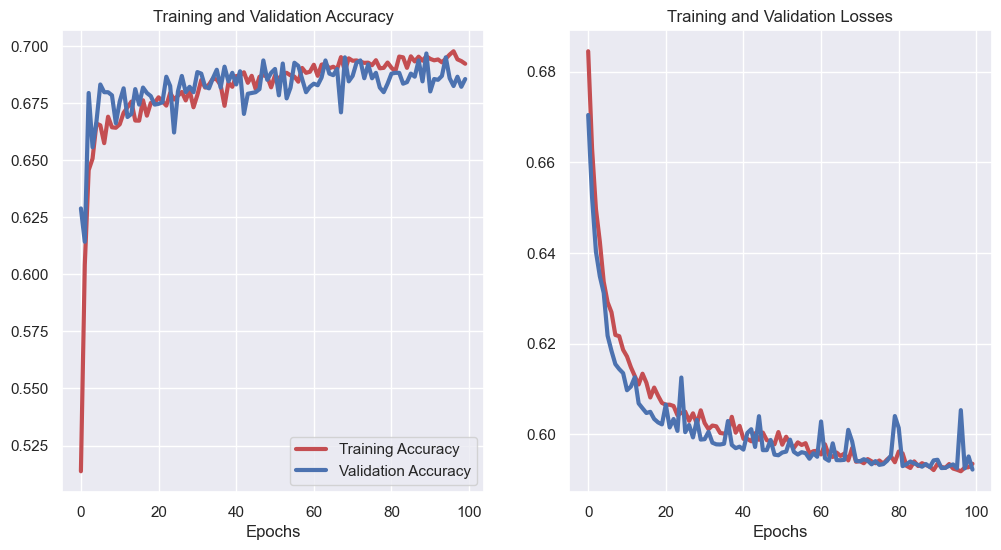

Training Classification Report: 
               precision    recall  f1-score   support

         0.0      0.693     0.701     0.697     10260
         1.0      0.700     0.692     0.696     10341

    accuracy                          0.697     20601
   macro avg      0.697     0.697     0.697     20601
weighted avg      0.697     0.697     0.697     20601


Validation Classification Report: 
               precision    recall  f1-score   support

         0.0      0.680     0.697     0.688      1466
         1.0      0.692     0.674     0.683      1477

    accuracy                          0.686      2943
   macro avg      0.686     0.686     0.686      2943
weighted avg      0.686     0.686     0.686      2943


Testing Classification Report: 
               precision    recall  f1-score   support

         0.0      0.672     0.687     0.680      1303
         1.0      0.683     0.668     0.675      1314

    accuracy                          0.677      2617
   macro avg      0.678

In [28]:
from sklearn.linear_model import LogisticRegression

logreg_cls =  tf.keras.Sequential([tf.keras.layers.Dense(2, activation = 'sigmoid', input_dim = HEIGHT * WIDTH)])
logreg_cls.compile(optimizer = tf.optimizers.Adam(0.002), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
history = logreg_cls.fit(x_train.reshape(n_train, -1), 
                        y_train,
                        batch_size = 512,
                        validation_data=[x_val.reshape(n_val, -1), y_val],
                        validation_batch_size=128,
                        epochs = 100,
                        callbacks =  [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10),
                                     tf.keras.callbacks.ModelCheckpoint(str = 'val_loss', save_best_only = True, save_weights_only = True, filepath= "LR_No_Aug_HSV")],
                        verbose = 1)

logreg_cls.load_weights('LR_No_Aug_HSV')
preds_train = np.argmax(logreg_cls.predict(x_train.reshape(n_train, -1)), axis = 1)
preds_val   = np.argmax(logreg_cls.predict(x_val.reshape(n_val, -1)), axis = 1)
preds_test  = np.argmax(logreg_cls.predict(x_test.reshape(n_test, -1)), axis = 1)

fig, ax = plot_history(history)

fig.savefig(PLOT_SAVE + "logreg_unaug_losscurve_HSV.png", facecolor = 'white')

print("Training Classification Report: \n", classification_report(y_train, preds_train, digits = N_DIGITS))
print("\nValidation Classification Report: \n", classification_report(y_val, preds_val, digits = N_DIGITS))
print("\nTesting Classification Report: \n", classification_report(y_test, preds_test, digits = N_DIGITS))

#### Decision Trees

In [29]:
from sklearn.tree import DecisionTreeClassifier

dt_cls =  DecisionTreeClassifier(criterion = 'gini', splitter = 'best', max_depth = 12, min_samples_split = 2, )
dt_cls.fit(x_train.reshape(n_train, -1), y_train)
preds_train = dt_cls.predict(x_train.reshape(n_train, -1))
preds_val   = dt_cls.predict(x_val.reshape(n_val, -1))
preds_test  = dt_cls.predict(x_test.reshape(n_test, -1))

print("Training Classification Report: \n", classification_report(y_train, preds_train, digits = N_DIGITS))
print("\nValidation Classification Report: \n", classification_report(y_val, preds_val, digits = N_DIGITS))
print("\nTesting Classification Report: \n", classification_report(y_test, preds_test, digits = N_DIGITS))

# eval = testing_module.ModelEvaluation(y_val, 
#     nb_cls.predict(x_val.reshape(n_val, -1)),
#     model_reference_name = 'Naive Bayes',
#     model_type = 'classification',
#     plot_classification_metric = ['roc_auc']) # if classification
# eval.evaluate(evaluate_save= True, plots_show = True)

Training Classification Report: 
               precision    recall  f1-score   support

         0.0      0.759     0.842     0.798     10260
         1.0      0.824     0.735     0.777     10341

    accuracy                          0.788     20601
   macro avg      0.792     0.788     0.788     20601
weighted avg      0.792     0.788     0.788     20601


Validation Classification Report: 
               precision    recall  f1-score   support

         0.0      0.667     0.756     0.709      1466
         1.0      0.721     0.626     0.670      1477

    accuracy                          0.691      2943
   macro avg      0.694     0.691     0.690      2943
weighted avg      0.694     0.691     0.689      2943


Testing Classification Report: 
               precision    recall  f1-score   support

         0.0      0.647     0.744     0.692      1303
         1.0      0.702     0.597     0.645      1314

    accuracy                          0.670      2617
   macro avg      0.674

#### XGBoost

In [30]:
tf.keras.backend.clear_session()
from xgboost import XGBClassifier

xgb_cls = XGBClassifier(max_depth = 10, objective = 'reg:logistic',
                            num_parallel_tree = 20, booster = 'gbtree',
                            gamma = 0.5, tree_method = 'gpu_hist', subsample = 0.4, reg_lambda = 1)
setattr(xgb_cls, 'verbosity', 1)
xgb_cls.fit(x_train.reshape(n_train, -1), y_train)
preds_train = xgb_cls.predict(x_train.reshape(n_train, -1))
preds_val   = xgb_cls.predict(x_val.reshape(n_val, -1))
preds_test  = xgb_cls.predict(x_test.reshape(n_test, -1))

print("Training Classification Report: \n", classification_report(y_train, preds_train, digits = N_DIGITS))
print("\nValidation Classification Report: \n", classification_report(y_val, preds_val, digits = N_DIGITS))
print("\nTesting Classification Report: \n", classification_report(y_test, preds_test, digits = N_DIGITS))
                  

XGBoostError: [12:14:05] C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0ac76685cf763591d-1/xgboost/xgboost-ci-windows/src/tree/updater_gpu_hist.cu:784: Exception in gpu_hist: [12:14:05] c:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ac76685cf763591d-1\xgboost\xgboost-ci-windows\src\data\../common/device_helpers.cuh:431: Memory allocation error on worker 0: bad allocation: cudaErrorMemoryAllocation: out of memory
- Free memory: 0
- Requested memory: 2147483648



#### SVM

In [ ]:
from sklearn.svm import SVC

svm_cls = SVC(kernel = 'poly', degree = 3, gamma = 'auto', max_iter = 250, verbose= True)
svm_cls.fit(x_train.reshape(n_train, -1), y_train)
preds_train = svm_cls.predict(x_train.reshape(n_train, -1))
preds_val   = svm_cls.predict(x_val.reshape(n_val, -1))
preds_test  = svm_cls.predict(x_test.reshape(n_test, -1))

print("Training Classification Report: \n", classification_report(y_train, preds_train, digits = N_DIGITS))
print("\nValidation Classification Report: \n", classification_report(y_val, preds_val, digits = N_DIGITS))
print("\nTesting Classification Report: \n", classification_report(y_test, preds_test, digits = N_DIGITS))
                  

[LibSVM]

c:\ProgramData\Anaconda3\envs\ml\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=250).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Training Classification Report: 
               precision    recall  f1-score   support

         0.0      0.581     0.102     0.174     10260
         1.0      0.510     0.927     0.658     10341

    accuracy                          0.516     20601
   macro avg      0.545     0.515     0.416     20601
weighted avg      0.545     0.516     0.417     20601


Validation Classification Report: 
               precision    recall  f1-score   support

         0.0      0.585     0.101     0.172      1466
         1.0      0.510     0.929     0.659      1477

    accuracy                          0.516      2943
   macro avg      0.548     0.515     0.415      2943
weighted avg      0.547     0.516     0.416      2943


Testing Classification Report: 
               precision    recall  f1-score   support

         0.0      0.590     0.106     0.180      1303
         1.0      0.511     0.927     0.659      1314

    accuracy                          0.518      2617
   macro avg      0.550

#### CNN Model

Epoch 1/50
81/81 [==============================] - 2s 14ms/step - loss: 0.1845 - accuracy: 0.9211 - val_loss: 0.0389 - val_accuracy: 0.9901
Epoch 2/50
81/81 [==============================] - 1s 12ms/step - loss: 0.0346 - accuracy: 0.9903 - val_loss: 0.0387 - val_accuracy: 0.9888
Epoch 3/50
81/81 [==============================] - 1s 12ms/step - loss: 0.0293 - accuracy: 0.9918 - val_loss: 0.0348 - val_accuracy: 0.9905
Epoch 4/50
81/81 [==============================] - 1s 12ms/step - loss: 0.0276 - accuracy: 0.9926 - val_loss: 0.0237 - val_accuracy: 0.9929
Epoch 5/50
81/81 [==============================] - 1s 12ms/step - loss: 0.0260 - accuracy: 0.9933 - val_loss: 0.0264 - val_accuracy: 0.9915
Epoch 6/50
81/81 [==============================] - 1s 12ms/step - loss: 0.0229 - accuracy: 0.9936 - val_loss: 0.0241 - val_accuracy: 0.9925
Epoch 7/50
81/81 [==============================] - 1s 11ms/step - loss: 0.0219 - accuracy: 0.9940 - val_loss: 0.0288 - val_accuracy: 0.9918
Epoch 8/50
81

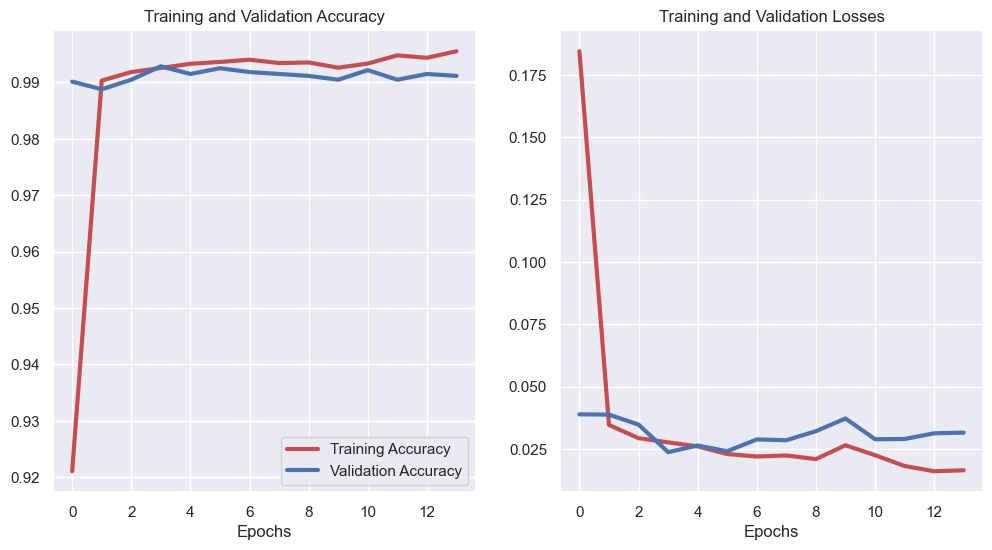

82/82 [==============================] - 0s 1ms/step
Training Classification Report: 
               precision    recall  f1-score   support

         0.0      0.995     0.995     0.995     10260
         1.0      0.995     0.995     0.995     10341

    accuracy                          0.995     20601
   macro avg      0.995     0.995     0.995     20601
weighted avg      0.995     0.995     0.995     20601


Validation Classification Report: 
               precision    recall  f1-score   support

         0.0      0.993     0.992     0.993      1466
         1.0      0.993     0.993     0.993      1477

    accuracy                          0.993      2943
   macro avg      0.993     0.993     0.993      2943
weighted avg      0.993     0.993     0.993      2943


Testing Classification Report: 
               precision    recall  f1-score   support

         0.0      0.996     0.993     0.995      1303
         1.0      0.993     0.996     0.995      1314

    accuracy            

In [ ]:
cnn = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), padding = 'same', activation = 'relu', input_shape = x_train[0].shape),
    tf.keras.layers.MaxPool2D((3,3), padding = 'same'),

    tf.keras.layers.UpSampling2D((4,4)),

    tf.keras.layers.Conv2D(32, (3,3), padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPool2D((3,3), padding = 'same'),

    tf.keras.layers.Conv2D(32, (2,2), padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPool2D((2,2), padding = 'same'),


    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation = 'sigmoid')
])

cnn.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.003),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

history = cnn.fit(
            x_train, y_train, batch_size = 256,
            epochs = 50,
            validation_data = [x_val, y_val],
            validation_batch_size = 256,
            callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10),
                         tf.keras.callbacks.ModelCheckpoint(str = 'val_loss', save_best_only = True, save_weights_only = True, filepath= "CNN_No_Aug_HSV")]
        )


cnn.load_weights('CNN_No_Aug_HSV')
fig, ax = plot_history(history)

fig.savefig(PLOT_SAVE + "CNN_unaug_losscurve_HSV.png", facecolor = 'white')
preds_train = np.argmax(cnn.predict(x_train), axis = 1)
preds_val   = np.argmax(cnn.predict(x_val), axis = 1)
preds_test  = np.argmax(cnn.predict(x_test), axis = 1)

print("Training Classification Report: \n", classification_report(y_train, preds_train, digits = N_DIGITS))
print("\nValidation Classification Report: \n", classification_report(y_val, preds_val, digits = N_DIGITS))
print("\nTesting Classification Report: \n", classification_report(y_test, preds_test, digits = N_DIGITS))

### Augmented Dataset

#### Naive Bayes

In [ ]:
from sklearn import naive_bayes

nb_cls = naive_bayes.GaussianNB()
nb_cls.fit(x_train_aug.reshape(n_aug_train, -1), y_train_aug)
preds_train = nb_cls.predict(x_train_aug.reshape(n_aug_train, -1))
preds_val   = nb_cls.predict(x_val.reshape(n_val, -1))
preds_test  = nb_cls.predict(x_test.reshape(n_test, -1))

print("Training Classification Report: \n", classification_report(y_train_aug, preds_train, digits = N_DIGITS))
print("\nValidation Classification Report: \n", classification_report(y_val, preds_val, digits = N_DIGITS))
print("\nTesting Classification Report: \n", classification_report(y_test, preds_test, digits = N_DIGITS))

Training Classification Report: 
               precision    recall  f1-score   support

         0.0      0.609     0.643     0.625     20520
         1.0      0.625     0.590     0.607     20682

    accuracy                          0.616     41202
   macro avg      0.617     0.617     0.616     41202
weighted avg      0.617     0.616     0.616     41202


Validation Classification Report: 
               precision    recall  f1-score   support

         0.0      0.592     0.480     0.530      1466
         1.0      0.565     0.671     0.614      1477

    accuracy                          0.576      2943
   macro avg      0.578     0.576     0.572      2943
weighted avg      0.578     0.576     0.572      2943


Testing Classification Report: 
               precision    recall  f1-score   support

         0.0      0.629     0.477     0.543      1303
         1.0      0.582     0.721     0.644      1314

    accuracy                          0.600      2617
   macro avg      0.605

#### Logistic Regression

Epoch 1/100
81/81 [==============================] - 1s 4ms/step - loss: 0.6909 - accuracy: 0.4779 - val_loss: 0.6887 - val_accuracy: 0.4893
Epoch 2/100
81/81 [==============================] - 0s 3ms/step - loss: 0.6864 - accuracy: 0.4897 - val_loss: 0.6861 - val_accuracy: 0.4958
Epoch 3/100
81/81 [==============================] - 0s 2ms/step - loss: 0.6826 - accuracy: 0.5026 - val_loss: 0.6828 - val_accuracy: 0.5076
Epoch 4/100
81/81 [==============================] - 0s 2ms/step - loss: 0.6794 - accuracy: 0.5225 - val_loss: 0.6815 - val_accuracy: 0.5144
Epoch 5/100
81/81 [==============================] - 0s 2ms/step - loss: 0.6766 - accuracy: 0.5404 - val_loss: 0.6790 - val_accuracy: 0.5335
Epoch 6/100
81/81 [==============================] - 0s 2ms/step - loss: 0.6740 - accuracy: 0.5569 - val_loss: 0.6764 - val_accuracy: 0.5644
Epoch 7/100
81/81 [==============================] - 0s 3ms/step - loss: 0.6716 - accuracy: 0.5749 - val_loss: 0.6752 - val_accuracy: 0.5736
Epoch 8/100
8

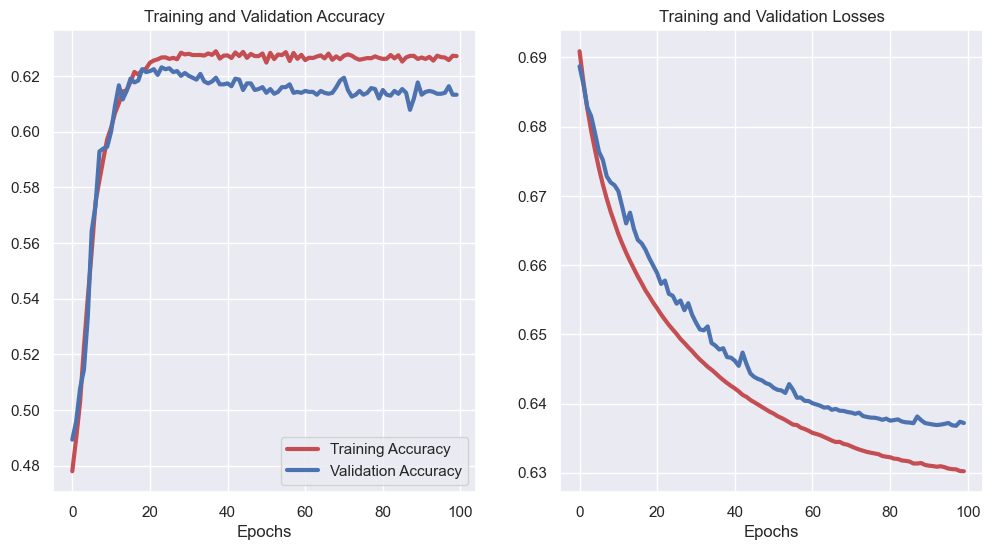

Training Classification Report: 
               precision    recall  f1-score   support

         0.0      0.648     0.529     0.583     20520
         1.0      0.605     0.716     0.656     20682

    accuracy                          0.623     41202
   macro avg      0.627     0.622     0.619     41202
weighted avg      0.627     0.623     0.619     41202


Validation Classification Report: 
               precision    recall  f1-score   support

         0.0      0.639     0.514     0.570      1466
         1.0      0.596     0.712     0.649      1477

    accuracy                          0.613      2943
   macro avg      0.618     0.613     0.609      2943
weighted avg      0.617     0.613     0.609      2943


Testing Classification Report: 
               precision    recall  f1-score   support

         0.0      0.652     0.513     0.574      1303
         1.0      0.601     0.729     0.659      1314

    accuracy                          0.621      2617
   macro avg      0.627

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg_cls =  tf.keras.Sequential([tf.keras.layers.Dense(2, activation = 'sigmoid', input_dim = HEIGHT * WIDTH)])
logreg_cls.compile(optimizer = tf.optimizers.Adam(0.0001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
history = logreg_cls.fit(x_train_aug.reshape(n_aug_train, -1), 
                        y_train_aug,
                        batch_size = 512,
                        validation_data=[x_val.reshape(n_val, -1), y_val],
                        validation_batch_size=128,
                        epochs = 100,
                        callbacks =  [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10),
                                    tf.keras.callbacks.ModelCheckpoint(str = 'val_loss', save_best_only = True, save_weights_only = True, filepath= "LR_Aug_HSV")])
preds_train = np.argmax(logreg_cls.predict(x_train_aug.reshape(n_aug_train, -1)), axis = 1)
preds_val   = np.argmax(logreg_cls.predict(x_val.reshape(n_val, -1)), axis = 1)
preds_test  = np.argmax(logreg_cls.predict(x_test.reshape(n_test, -1)), axis = 1)

logreg_cls.load_weights('LR_Aug_HSV')
fig, ax = plot_history(history)

fig.savefig(PLOT_SAVE + "logreg_aug_losscurve_HSV.png", facecolor = 'white')

print("Training Classification Report: \n", classification_report(y_train_aug, preds_train, digits = N_DIGITS))
print("\nValidation Classification Report: \n", classification_report(y_val, preds_val, digits = N_DIGITS))
print("\nTesting Classification Report: \n", classification_report(y_test, preds_test, digits = N_DIGITS))

#### Decision Trees

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt_cls =  DecisionTreeClassifier(criterion = 'gini', splitter = 'best', max_depth = 25, min_samples_split = 2, )
dt_cls.fit(x_train_aug.reshape(n_aug_train, -1), y_train_aug)
preds_train = dt_cls.predict(x_train_aug.reshape(n_aug_train, -1))
preds_val   = dt_cls.predict(x_val.reshape(n_val, -1))
preds_test  = dt_cls.predict(x_test.reshape(n_test, -1))

print("Training Classification Report: \n", classification_report(y_train_aug, preds_train, digits = N_DIGITS))
print("\nValidation Classification Report: \n", classification_report(y_val, preds_val, digits = N_DIGITS))
print("\nTesting Classification Report: \n", classification_report(y_test, preds_test, digits = N_DIGITS))

Training Classification Report: 
               precision    recall  f1-score   support

         0.0      0.774     0.998     0.871     20520
         1.0      0.997     0.710     0.829     20682

    accuracy                          0.853     41202
   macro avg      0.885     0.854     0.850     41202
weighted avg      0.886     0.853     0.850     41202


Validation Classification Report: 
               precision    recall  f1-score   support

         0.0      0.699     0.950     0.805      1466
         1.0      0.922     0.594     0.722      1477

    accuracy                          0.771      2943
   macro avg      0.810     0.772     0.764      2943
weighted avg      0.811     0.771     0.764      2943


Testing Classification Report: 
               precision    recall  f1-score   support

         0.0      0.706     0.941     0.807      1303
         1.0      0.913     0.612     0.733      1314

    accuracy                          0.776      2617
   macro avg      0.809

#### XGBoost

In [ ]:
tf.keras.backend.clear_session()

from xgboost import XGBClassifier

xgb_cls = XGBClassifier(max_depth = 10, objective = 'reg:logistic',
                            num_parallel_tree = 20, booster = 'gbtree',
                            gamma = 0.5, tree_method = 'gpu_hist', subsample = 0.4, reg_lambda = 1)
xgb_cls.fit(x_train_aug.reshape(n_aug_train, -1), y_train_aug)
preds_train = xgb_cls.predict(x_train_aug.reshape(n_aug_train, -1))
preds_val   = xgb_cls.predict(x_val.reshape(n_val, -1))
preds_test  = xgb_cls.predict(x_test.reshape(n_test, -1))

print("Training Classification Report: \n", classification_report(y_train_aug, preds_train, digits = N_DIGITS))
print("\nValidation Classification Report: \n", classification_report(y_val, preds_val, digits = N_DIGITS))
print("\nTesting Classification Report: \n", classification_report(y_test, preds_test, digits = N_DIGITS))
                  

XGBoostError: [11:59:14] C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0ac76685cf763591d-1/xgboost/xgboost-ci-windows/src/tree/updater_gpu_hist.cu:784: Exception in gpu_hist: [11:59:14] c:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ac76685cf763591d-1\xgboost\xgboost-ci-windows\src\data\../common/device_helpers.cuh:431: Memory allocation error on worker 0: bad allocation: cudaErrorMemoryAllocation: out of memory
- Free memory: 0
- Requested memory: 2147483648



#### SVM

In [ ]:
from sklearn.svm import SVC

svm_cls = SVC(kernel = 'rbf', max_iter = 250, verbose= True)
svm_cls.fit(x_train_aug.reshape(n_aug_train, -1), y_train_aug)
preds_train = svm_cls.predict(x_train_aug.reshape(n_aug_train, -1))
preds_val   = svm_cls.predict(x_val.reshape(n_val, -1))
preds_test  = svm_cls.predict(x_test.reshape(n_test, -1))

print("Training Classification Report: \n", classification_report(y_train_aug, preds_train, digits = N_DIGITS))
print("\nValidation Classification Report: \n", classification_report(y_val, preds_val, digits = N_DIGITS))
print("\nTesting Classification Report: \n", classification_report(y_test, preds_test, digits = N_DIGITS))
                  

[LibSVM]

c:\ProgramData\Anaconda3\envs\ml\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=250).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Training Classification Report: 
               precision    recall  f1-score   support

         0.0      0.419     0.492     0.453     20520
         1.0      0.391     0.324     0.354     20682

    accuracy                          0.408     41202
   macro avg      0.405     0.408     0.404     41202
weighted avg      0.405     0.408     0.404     41202


Validation Classification Report: 
               precision    recall  f1-score   support

         0.0      0.426     0.516     0.467      1466
         1.0      0.391     0.309     0.345      1477

    accuracy                          0.412      2943
   macro avg      0.409     0.413     0.406      2943
weighted avg      0.409     0.412     0.406      2943


Testing Classification Report: 
               precision    recall  f1-score   support

         0.0      0.410     0.519     0.458      1303
         1.0      0.352     0.260     0.299      1314

    accuracy                          0.389      2617
   macro avg      0.381

#### CNN Model

Epoch 1/100
81/81 [==============================] - 2s 23ms/step - loss: 0.2579 - accuracy: 0.8870 - val_loss: 0.0546 - val_accuracy: 0.9834
Epoch 2/100
81/81 [==============================] - 2s 22ms/step - loss: 0.0754 - accuracy: 0.9782 - val_loss: 0.0351 - val_accuracy: 0.9901
Epoch 3/100
81/81 [==============================] - 2s 22ms/step - loss: 0.0529 - accuracy: 0.9854 - val_loss: 0.0319 - val_accuracy: 0.9912
Epoch 4/100
81/81 [==============================] - 2s 26ms/step - loss: 0.0482 - accuracy: 0.9860 - val_loss: 0.0278 - val_accuracy: 0.9932
Epoch 5/100
81/81 [==============================] - 2s 21ms/step - loss: 0.0463 - accuracy: 0.9868 - val_loss: 0.0298 - val_accuracy: 0.9912
Epoch 6/100
81/81 [==============================] - 2s 21ms/step - loss: 0.0442 - accuracy: 0.9873 - val_loss: 0.0269 - val_accuracy: 0.9929
Epoch 7/100
81/81 [==============================] - 2s 21ms/step - loss: 0.0419 - accuracy: 0.9880 - val_loss: 0.0254 - val_accuracy: 0.9925
Epoch 

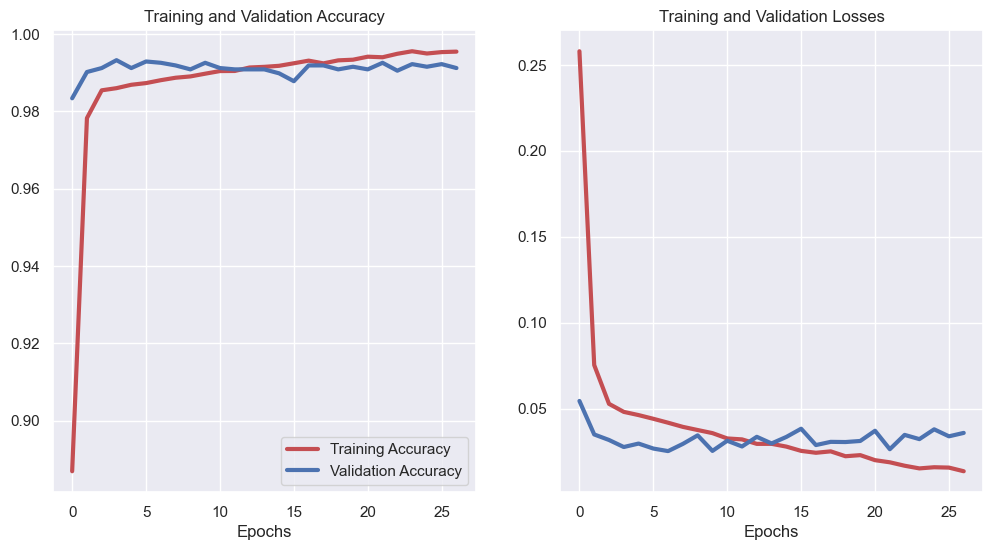

82/82 [==============================] - 0s 1ms/step
Training Classification Report: 
               precision    recall  f1-score   support

         0.0      0.986     0.994     0.990     20520
         1.0      0.994     0.986     0.990     20682

    accuracy                          0.990     41202
   macro avg      0.990     0.990     0.990     41202
weighted avg      0.990     0.990     0.990     41202


Validation Classification Report: 
               precision    recall  f1-score   support

         0.0      0.995     0.990     0.992      1466
         1.0      0.990     0.995     0.993      1477

    accuracy                          0.993      2943
   macro avg      0.993     0.993     0.993      2943
weighted avg      0.993     0.993     0.993      2943


Testing Classification Report: 
               precision    recall  f1-score   support

         0.0      0.993     0.994     0.993      1303
         1.0      0.994     0.993     0.994      1314

    accuracy            

In [ ]:
cnn = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), padding = 'same', activation = 'relu', input_shape = x_train[0].shape),
    tf.keras.layers.MaxPool2D((3,3), padding = 'same'),

    tf.keras.layers.UpSampling2D((4,4)),

    tf.keras.layers.Conv2D(32, (3,3), padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPool2D((3,3), padding = 'same'),

    tf.keras.layers.Conv2D(32, (2,2), padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPool2D((2,2), padding = 'same'),


    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation = 'sigmoid')
])

cnn.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

history = cnn.fit(
            x_train_aug, y_train_aug, batch_size = 512,
            epochs = 100,
            shuffle = True,
            validation_data = [x_val, y_val],
            validation_batch_size = 256,
            callbacks = [
                tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 20),
                tf.keras.callbacks.ModelCheckpoint(str = 'val_loss', save_best_only = True, save_weights_only = True, filepath= "CNN_Aug_HSV")
            ]
        )

fig, ax = plot_history(history)

cnn.load_weights('CNN_Aug_HSV')

fig.savefig(PLOT_SAVE + "CNN_aug_losscurve_HSV.png", facecolor = 'white')
preds_train = np.argmax(cnn.predict(x_train_aug), axis = 1)
preds_val   = np.argmax(cnn.predict(x_val), axis = 1)
preds_test  = np.argmax(cnn.predict(x_test), axis = 1)

print("Training Classification Report: \n", classification_report(y_train_aug, preds_train, digits = N_DIGITS))
print("\nValidation Classification Report: \n", classification_report(y_val, preds_val, digits = N_DIGITS))
print("\nTesting Classification Report: \n", classification_report(y_test, preds_test, digits = N_DIGITS))